# 1. Import libraries, load data

In [55]:
#General, EDA, plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np
from numpy.fft import fft, fftfreq, ifft
from scipy.signal import savgol_filter
import os, io
import time

#Time Series Analysis
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

#ML Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')




This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759) from 01.01.1979 to 31.12.2021

In [56]:
raw_data = pd.read_csv("../data/temp_data.txt", delimiter=',',skiprows=19) #data (header) starts at line 20

# 2. EDA

## 2.1. Create clean-data

In [57]:
raw_data.head() #data from 01.01.1979...

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [58]:
raw_data.tail() #data until 30.08.2022

,SOUID,DATE,TG,Q_TG
53564,111448,20220827,205,0
53565,111448,20220828,177,0
53566,100133,20220829,166,0
53567,100133,20220830,172,0
53568,111448,20220831,-9999,9


In [59]:
#Rename Columns
raw_data.columns = ['id', 'date', 'temp', 'quality']

raw_data.head()

,id,date,temp,quality
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [60]:
#select just date with date>=01.01.1960
raw_data=raw_data[(raw_data['date'].astype(str)>='1990-01-01')]
raw_data.head()

,id,date,temp,quality
41638,111448,19900101,-17,0
41639,111448,19900102,-14,0
41640,111448,19900103,-4,0
41641,111448,19900104,-14,0
41642,111448,19900105,-2,0


In [61]:
# changing date column to pandas datetime format
raw_data['date'] = raw_data['date'].astype(str)
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.head()

,id,date,temp,quality
41638,111448,1990-01-01,-17,0
41639,111448,1990-01-02,-14,0
41640,111448,1990-01-03,-4,0
41641,111448,1990-01-04,-14,0
41642,111448,1990-01-05,-2,0


In [62]:
#Set index to date
raw_data = raw_data.set_index("date")
raw_data.head()

,id,temp,quality
date,,,
1990-01-01,111448,-17,0
1990-01-02,111448,-14,0
1990-01-03,111448,-4,0
1990-01-04,111448,-14,0
1990-01-05,111448,-2,0


In [63]:
# checking data coming from a single station
raw_data['id'].nunique()

2

In [64]:
# checking all data points are not missing
raw_data['quality'].value_counts() 

0    11930
9        1
Name: quality, dtype: int64

In [65]:
#id=9
raw_data[raw_data['quality']==9]

,id,temp,quality
date,,,
2022-08-31,111448,-9999,9


In [66]:
#drop row with quality=9
raw_data=raw_data.drop(raw_data[raw_data['quality']==9].index)

In [67]:
# dropping id and quality column, not necessary
raw_data.drop(['id', 'quality'], axis=1, inplace=True)
raw_data.head()

,temp
date,
1990-01-01,-17
1990-01-02,-14
1990-01-03,-4
1990-01-04,-14
1990-01-05,-2


In [68]:
#divide temp by 10
raw_data['temp']=raw_data['temp'].apply(lambda x: x/10)
raw_data.head()

,temp
date,
1990-01-01,-1.7
1990-01-02,-1.4
1990-01-03,-0.4
1990-01-04,-1.4
1990-01-05,-0.2


In [69]:
clean_data=raw_data

## 2.2. Inspire clean-data

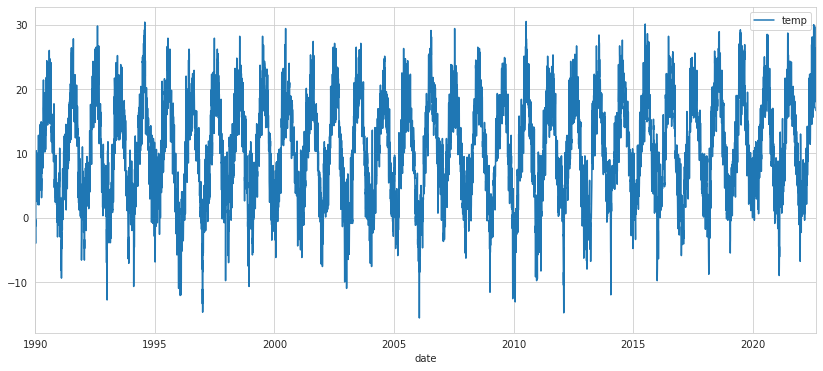

In [70]:
# taking a look at the data
clean_data.plot(); #seems to follow a linear trend 

In [71]:
def qcd_variance(series,window):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

In [72]:
# quartile coefficient of dispersion
qcd_variance(clean_data['temp'],40) #nearly additive model

quartile coefficient of dispersion: 0.326395


In [73]:
def rolling_plot(df,year):
    window = int(year * 365.24)
    plt.rcParams['figure.figsize'] = (16,6)
    df.rolling(window).mean().plot()
    sns.despine()

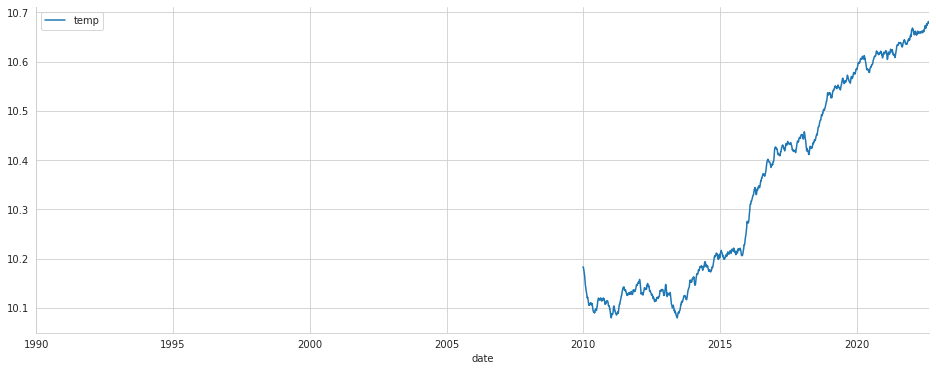

In [74]:
# take a closer look to  trend of global warming
rolling_plot(clean_data,20) #obviously increasing temperature

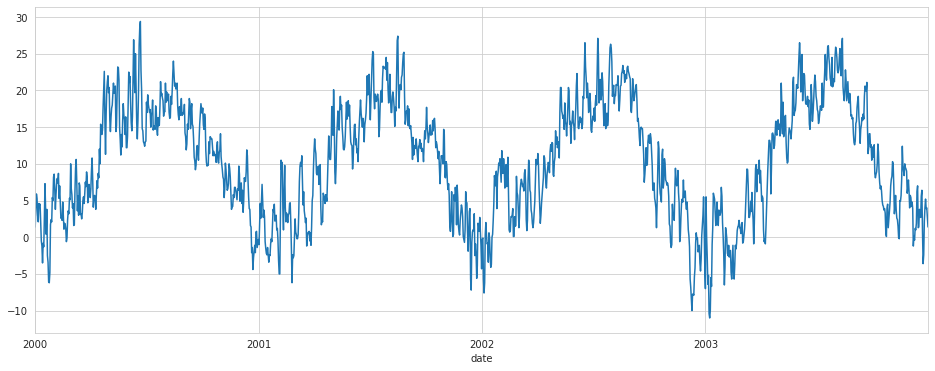

In [75]:
# taking a closer look at seasonality 
clean_data['temp'].loc['2000':'2003'].plot();

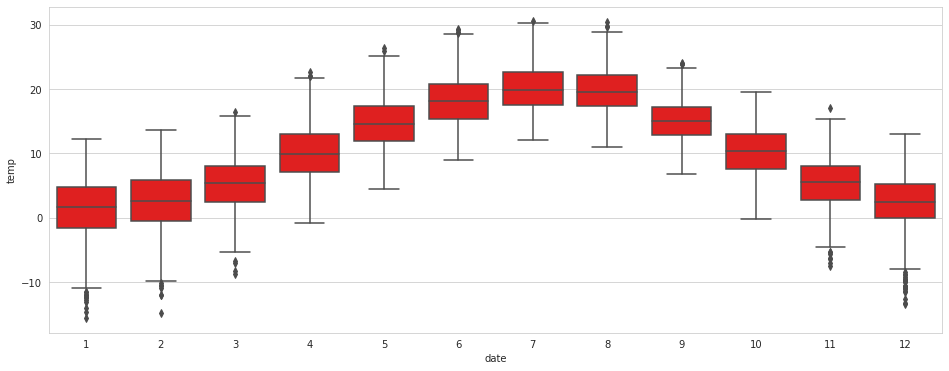

In [76]:
#pattern month --> median highest in summer, lowest in winter --> SURPRISE!
sns.boxplot(x=clean_data.index.month,y=clean_data['temp'],color="red");

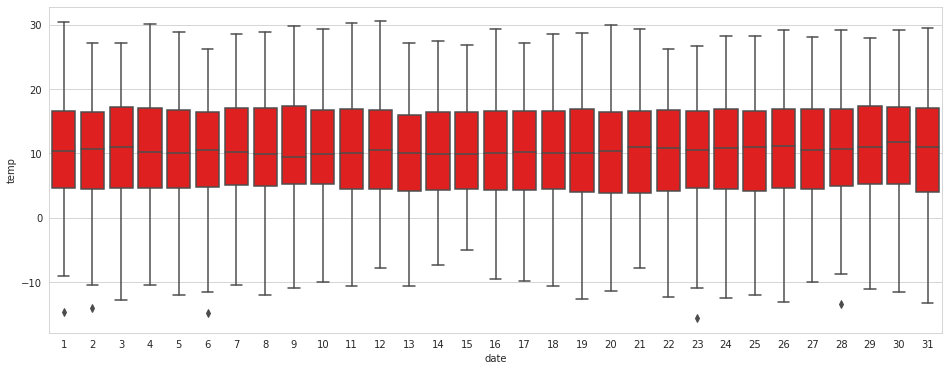

In [77]:
#pattern day in month 
sns.boxplot(x=clean_data.index.day,y=clean_data['temp'],color="red"); # temperature is indepent from day itself in a month

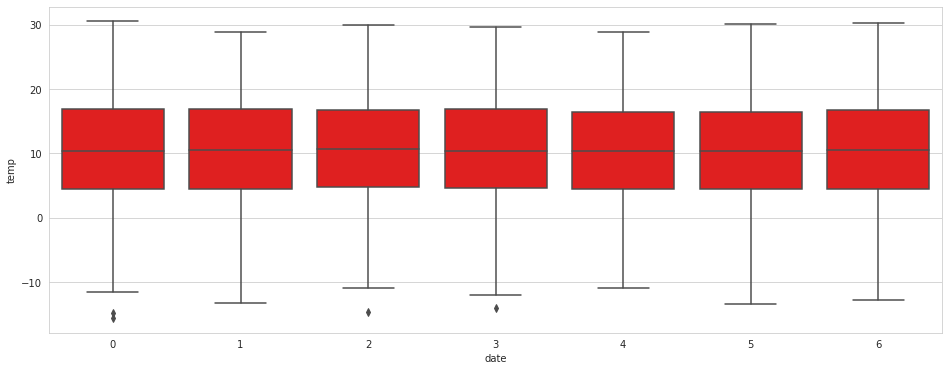

In [78]:
#pattern of day of week
sns.boxplot(x=clean_data.index.dayofweek,y=clean_data['temp'],color="red"); # temperature is indepent from day itself in a week

## 2.3. Conclusion EDA

- (small) Trend exists over the years (see rolling plot) --> data is not stationary
- huge seasonality effect --> 1 season = 1 year = 12 monthts = 365 days
- seems to be additive time series because low quartile coefficient of dispersion

Set up 2 Approaches to forecast temperature:
- #1: 
    - removing noise from data
    - Extract trend, seasonality manually and model them by using Linear Regression
    - model remainder with ARIMA
    - forecasting by adding LR and ARIMA predictions to a short-term-temp-prediction (5days)

# 3. Train-Test-Split

In [79]:
# divide into train and test

#train year 1960 - 2021
df_train = clean_data.loc[:'2021']
df_test=clean_data.loc['2022']
df_train.shape, df_test.shape

((11688, 1), (242, 1))

In [80]:
df_train.tail()

,temp
date,
2021-12-27,-3.9
2021-12-28,-0.5
2021-12-29,4.5
2021-12-30,9.3
2021-12-31,13.0


In [81]:
df_test.head()

,temp
date,
2022-01-01,12.0
2022-01-02,9.9
2022-01-03,8.9
2022-01-04,6.4
2022-01-05,3.8


# 4. Approach #1: Extract trend, seasonility, remainder step by step

## 4.1. Filter out Noise

In [82]:
#Using savgol-filter, windowlength is 151 datapoints
df_train['filter'] = savgol_filter(np.array(df_train['temp']), 99, polyorder=3, mode='nearest')
df_train['noise'] = df_train['temp'] - df_train['filter']

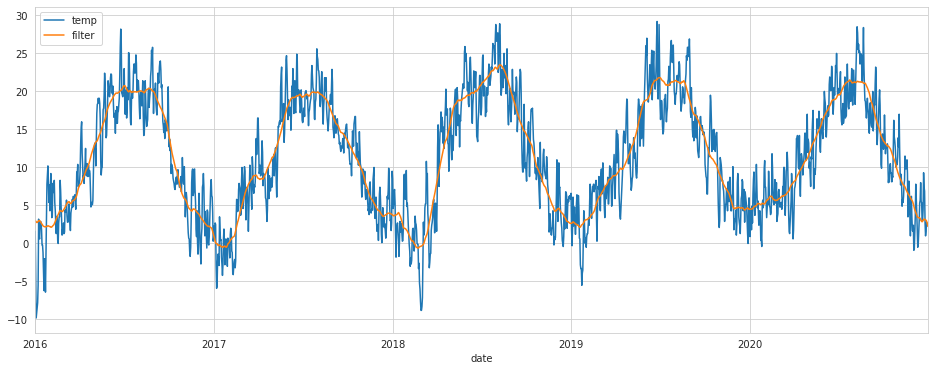

In [83]:
df_train[['temp','filter']]['2016-01-01':'2020-12-31'].plot(legend=True)
None

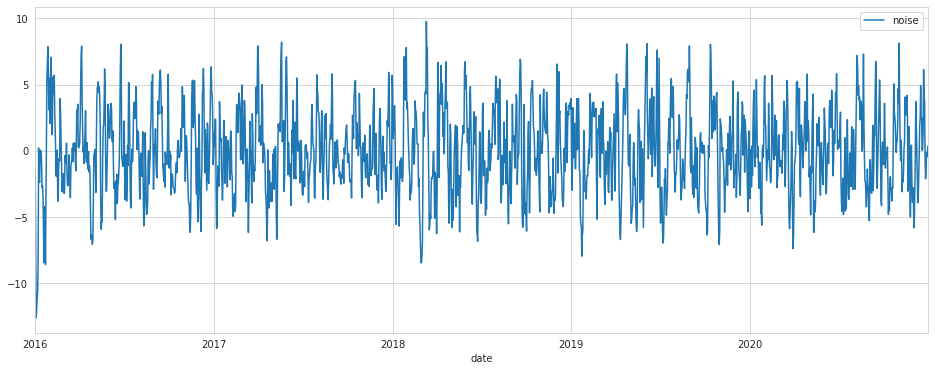

In [84]:
df_train['noise']['2016-01-01':'2020-12-31'].plot(legend=True)
None

## 4.2. Model the trend

In [85]:
#create a numerous timestep feature
df_train['timestep'] = list(range(df_train.shape[0]))
df_train.head()

,temp,filter,noise,timestep
date,,,,
1990-01-01,-1.7,0.960557,-2.660557,0
1990-01-02,-1.4,1.022508,-2.422508,1
1990-01-03,-0.4,1.107916,-1.507916,2
1990-01-04,-1.4,1.269856,-2.669856,3
1990-01-05,-0.2,1.401634,-1.601634,4


In [86]:
# build a LR model for trend
trend_model=LinearRegression()

In [87]:
X_trend=df_train[['timestep']]
y_trend=df_train[['filter']]

trend_model.fit(X_trend,y_trend)

LinearRegression()

In [88]:
df_train['f_trend']=trend_model.predict(X_trend)

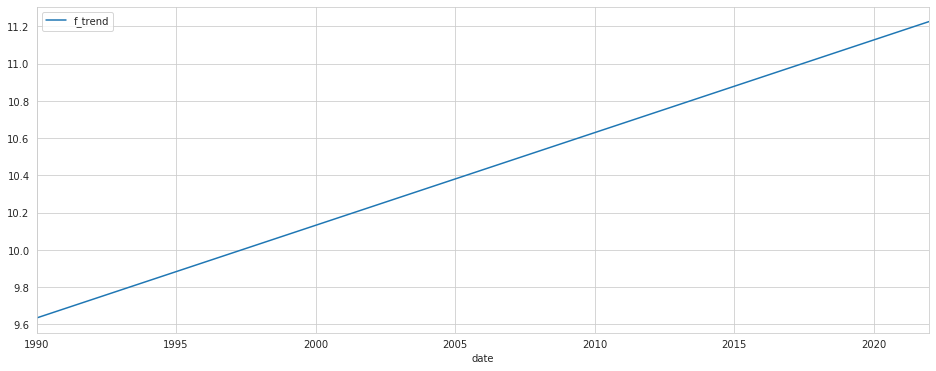

In [89]:
df_train[['f_trend']].plot()
None

## 4.3. Model the seasonality

In [90]:
#subtract trend from data
df_train['seasonality']=df_train['filter']-df_train['f_trend']

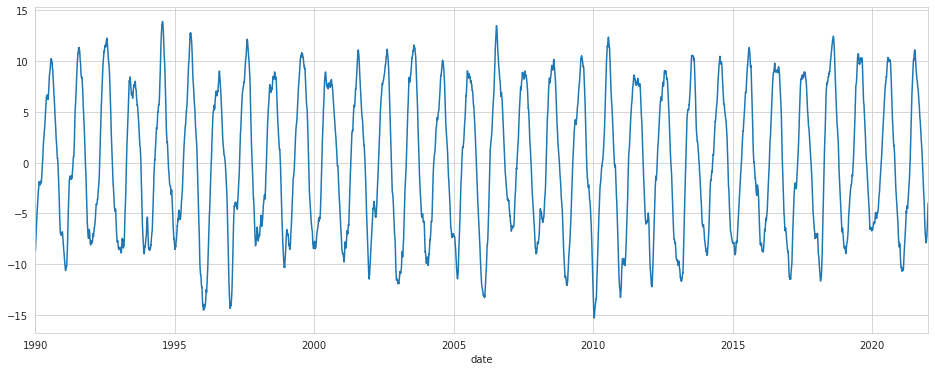

In [91]:
df_train['seasonality'].plot() #seems without a trend
None

In [92]:
# find mean and check if it is zero
mean_no_trend = df_train['seasonality'].mean()
print(f'mean filter value without trend: {mean_no_trend}') 

mean filter value without trend: 8.317173856620355e-16


Mean is going to be zero, trend is extracted

In [93]:
# Create additional features with sinus and cosinus to model seasonality
# Combination of sinus and cosinus is individually for every datapoint IN 1 YEAR!
# Between 2 or more different years, same timestamp means same combination of sin and cos --> describes seasonality!
# Extracting the day of year from index timestemp
day_of_year=[]
day_of_year=[x for x in df_train.index.dayofyear]
year = 365.25
df_train['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in day_of_year]
df_train['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in day_of_year]

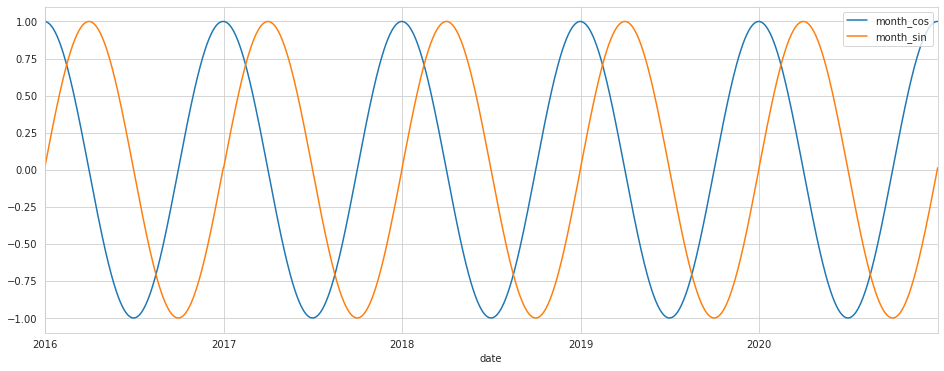

In [94]:
#Check
df_train[['month_cos','month_sin']].loc['2016':'2020'].plot();

In [95]:
df_train.tail()

,temp,filter,noise,timestep,f_trend,seasonality,month_cos,month_sin
date,,,,,,,,
2021-12-27,-3.9,6.336164,-10.236164,11683,11.226401,-4.890237,0.997329,-0.073045
2021-12-28,-0.5,6.576240,-7.076240,11684,11.226537,-4.650297,0.998438,-0.055879
2021-12-29,4.5,6.820243,-2.320243,11685,11.226673,-4.406430,0.999251,-0.038696
2021-12-30,9.3,7.019778,2.280222,11686,11.226809,-4.207032,0.999769,-0.021501
2021-12-31,13.0,7.228500,5.771500,11687,11.226946,-3.998446,0.999991,-0.004301


In [96]:
season_model=LinearRegression()

In [97]:
# set sines and cosines as X
X_seasonality = df_train.iloc[:,-2:]
y_seasonality = df_train[['seasonality']]

In [98]:
season_model.fit(X_seasonality,y_seasonality)

LinearRegression()

In [99]:
df_train['f_seasonality']=season_model.predict(X_seasonality)

In [100]:
df_train['f_trend_season']=df_train['f_trend']+df_train['f_seasonality']

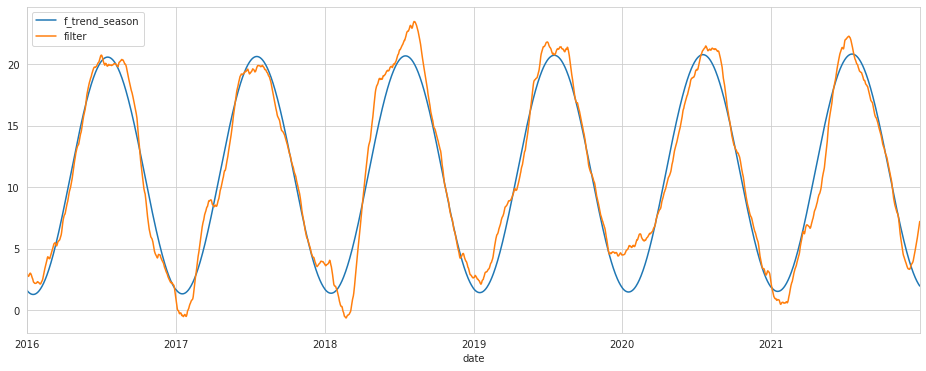

In [101]:
plt.rcParams['figure.figsize'] = (16,6)
df_train[['f_trend_season']]['2016-01-01':'2021-12-31'].plot(legend=True)
df_train['filter']['2016-01-01':'2021-12-31'].plot(legend=True)
None

## 4.4. Model the Remainder

### Extracting Remainder

In [102]:
# Extract Remainder
df_train['f_remainder']  = df_train['filter'] - df_train['f_trend_season']

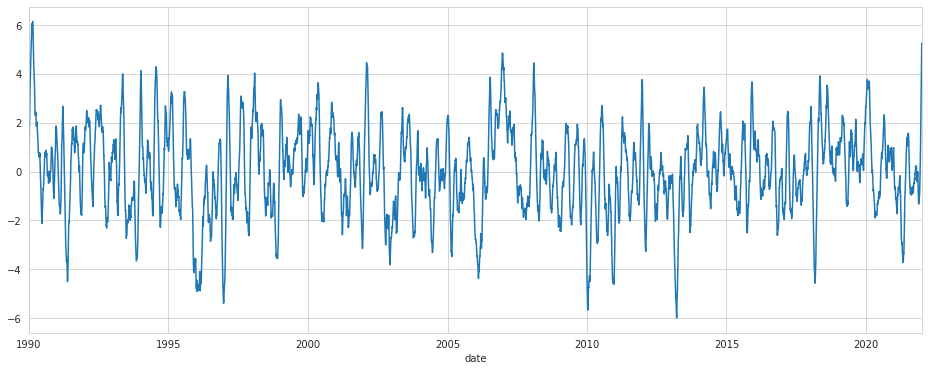

In [103]:
df_train['f_remainder'].plot(); #looks stationary

### Stationary test

In [104]:
def stationarity_test(timeseries,p_ct=0.003):
    adftest = adfuller(timeseries, autolag="AIC")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    print(f'p_adf: {round(adftest[1],6)}, p_kpss: {round(kpsstest[1],6)}')
    adf_,kpss_ = [(adftest[1]<p_ct),(kpsstest[1]>p_ct)]
    if adf_ and kpss_: print('The timeseries is stationary')
    if not(adf_) and not(kpss_): print('The timeseries is non-stationary')
    if not(adf_) and kpss_: print('The timeseries is trend-stationary')
    if adf_ and not(kpss_): print('The timeseries is difference-stationary')

In [105]:
#Check if Remainder is stationary
stationarity_test(df_train['f_remainder'])

p_adf: 0.0, p_kpss: 0.1
The timeseries is stationary


### define lags order

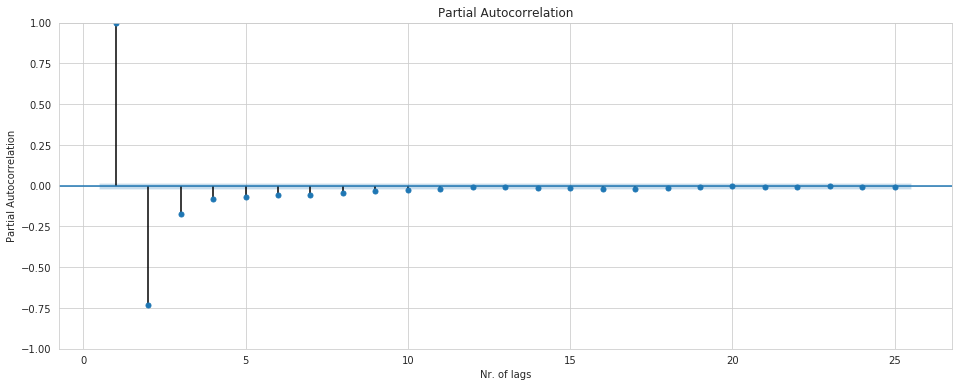

In [106]:
#partial autocorrelation
plot_pacf(df_train['f_remainder'],zero=False,lags=25) 
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
None # shows how many lags are necessary until the correlation between yt and yt-p is not correlated anymore in a 
# certain confindence intervall

PACF plot falls after 1 lag 
- AR(2) because last meaningful lag (2) is included

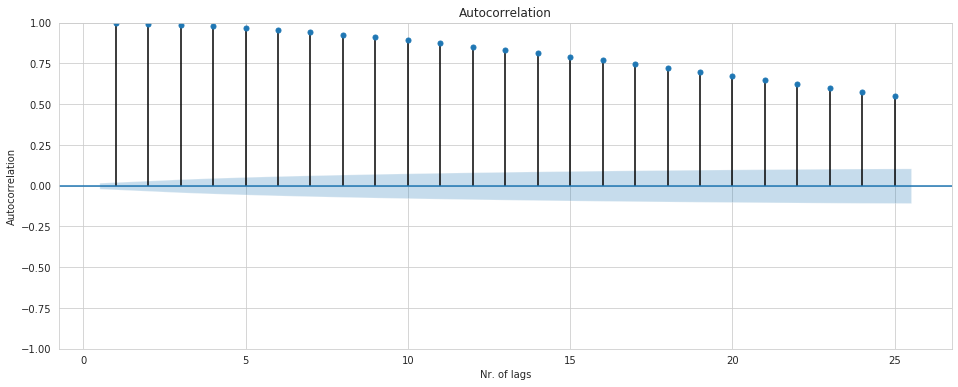

In [107]:
#autocorrelation function
plot_acf(df_train['f_remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')
None

ACF with slow decay

--> If the ACF-Plot is showing an exponential and slow decay, and the PACF-Plot shows a drop after a certain lag, we conclude that the data is best modelled by an AR(p) process. p is given by the last meaningful lag in the PACF-Plot.

### finding best ARIMA model

In [109]:
# Determine the best arima model p,i,q which minimizes AIC!
# p = number of AR lags
# q = number of MA lags
# d = the order of integration (if the data is stationary, d=0)
remainder_model = pm.auto_arima(
    df_train['f_remainder'],
    start_p=0,
    max_p=2,
    seasonality = False,
    stationarity = True, #d=0
    trace = True,
    n_jobs=-1
) 

Performing stepwise search to minimize aic
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=15886.017, Time=6.61 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46512.000, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=30558.060, Time=7.92 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=46510.000, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-34262.486, Time=19.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-30321.051, Time=17.16 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-37972.987, Time=17.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-37890.664, Time=13.69 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-38075.795, Time=32.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-35702.894, Time=21.72 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-38102.157, Time=41.76 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-36570.383, Time=27.09 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=-38132.465, Time=7.60 sec
 ARIMA(1

In [ ]:
# To print the summary 
print(remainder_model.summary())

In [ ]:
#predict in sample
df_train['f_remainder_pred'] = remainder_model.predict_in_sample()

In [ ]:
plt.rcParams['figure.figsize'] = (16,6)
df_train['f_remainder_pred']['2021-01-01':'2021-12-31'].plot()
df_train['f_remainder']['2021-01-01':'2021-12-31'].plot()
None

In [ ]:
#Add predicted remainder to trend_seasonal prediction
df_train['filter_pred'] = df_train['f_trend_season'] + df_train['f_remainder_pred']

In [ ]:
df_train[['filter','filter_pred']]

In [ ]:
plt.rcParams['figure.figsize'] = (16,6)
df_train['filter']['2021-01-01':'2021-12-31'].plot()
df_train['filter_pred']['2021-01-01':'2021-12-31'].plot()
None

## 4.5 Model the Noise

In [ ]:
#Check if Noise is stationary
stationarity_test(df_train['noise'])

In [ ]:
#partial autocorrelation
plot_pacf(df_train['noise'],zero=False,lags=25) 
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
None # shows how many lags are necessary until the correlation between yt and yt-p is not correlated anymore in a 
# certain confindence intervall

PACF plot falls after 1 lag 
- AR(2) because last meaningful lac (2) is included

In [ ]:
#autocorrelation function
plot_acf(df_train['noise'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')
None

In [ ]:
# Determine the best arima model p,i,q which minimizes AIC!
# p = number of AR lags
# q = number of MA lags
# d = the order of integration (if the data is stationary, d=0)
noise_model = pm.auto_arima(
    df_train['noise'],
    start_p=0,
    max_p=2,
    seasonality = False,
    stationarity = True,
    trace = True,
    n_jobs=-1
) 

In [ ]:
#predict in sample
df_train['noise_pred'] = noise_model.predict_in_sample()

In [ ]:
#Add predicted rnoise to filter_pred
df_train['temp_pred'] = df_train['filter_pred']  + df_train['noise_pred']


In [ ]:
plt.rcParams['figure.figsize'] = (16,6)
df_train['temp']['2021-01-01':'2021-12-31'].plot()
df_train['temp_pred']['2021-01-01':'2021-12-31'].plot()
None

In [ ]:
df_train.head()

# 4.6. Training Score

In [ ]:
# calculate rmse on training data
rmse_training = np.sqrt(mean_squared_error(df_train['temp'], df_train['temp_pred']))
rmse_training

# 4.7. Prediction

### Feature Engineering Test Set

In [ ]:
#create a continous timestep feature, start at last datapoint of trainset
df_test['timestep'] = list(range(df_train.shape[0],df_train.shape[0]+df_test.shape[0]))

In [ ]:
# Create additional features with sinus and cosinus to model seasonality
# Combination of sinus and cosinus is individually for every datapoint IN 1 YEAR!
# Between 2 or more different years, same timestamp means same combination of sin and cos --> describes seasonality!
# Extracting the day of year from index timestemp
day_of_year=[]
day_of_year=[x for x in df_test.index.dayofyear]
year = 365.25
df_test['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in day_of_year]
df_test['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in day_of_year]

In [ ]:
df_test[['month_cos','month_sin']].plot();

### Base-Line-Model (without Remainder)


In [ ]:
#drop temp as target
y_test=df_test['temp']

In [ ]:
#trend
X_trend_test=df_test[['timestep']]

df_test['f_trend']=trend_model.predict(X_trend_test)
df_test['f_trend'].head(10)

In [ ]:
#seasonality
X_trend_seasonality=df_test[['month_cos','month_sin']]
df_test['f_season']=season_model.predict(X_trend_seasonality)

In [ ]:
#Prediction Base Line
df_test['baseline_temp_pred'] = round(df_test['f_trend'] + df_test['f_season'] ,1)

In [ ]:
#Show 5 days prediction
df_test[['baseline_temp_pred','temp']].head(5)

In [ ]:
# calculate rmse Baseline
rmse_baseline_test = np.sqrt(mean_squared_error(df_test['2022-01-01':'2022-01-05']['temp'], df_test['2022-01-01':'2022-01-05']['baseline_temp_pred']))
rmse_baseline_test

### add remainder

In [ ]:
df_train['f_remainder'].tail(5)

In [ ]:
# remainder
df_test['f_remainder_pred'] = remainder_model.predict(df_test.shape[0], return_conf_int=True)[0]

In [ ]:
df_test['f_remainder_pred'].plot();

In [ ]:
#Prediction Base Line + remainder
df_test['temp_pred_0'] = round(df_test['f_trend'] + df_test['f_season']+ df_test['f_remainder_pred'],1)

In [ ]:
# calculate rmse Baseline + remainder
rmse_baseline_test = np.sqrt(mean_squared_error(df_test['temp']['2022-01-01':'2022-01-05'], df_test['temp_pred_0']['2022-01-01':'2022-01-05']))
rmse_baseline_test

### add noise

In [ ]:
# noise
df_test['noise_pred']=noise_model.predict(df_test.shape[0],return_conf_int=True)[0]

In [ ]:
df_test['noise_pred'].plot();

In [ ]:
df_test['temp_pred_1'] = round((df_test['f_trend'] + df_test['f_season'] + df_test['f_remainder_pred'] + df_test['noise_pred']),1)

### Prediction Approach #1

In [ ]:
# calculate rmse Baseline + remainder + noise
rmse_ap_1 = np.sqrt(mean_squared_error(df_test['temp']['2022-01-01':'2022-01-05'], df_test['temp_pred_1']['2022-01-01':'2022-01-05']))
rmse_ap_1

In [ ]:
# 5-day prediction
df_test[['temp','temp_pred_1']].head(5).plot();

# 5. Approach #2:  ARIMA with the whole time series

# 5.1. Check stationary

In [ ]:
stationarity_test(df_train['temp'])

Although we did not extract trend and saisonality the time series is already stationary --> no differenciating necessary

# 5.2. (partial) autocorrelation

In [ ]:
plot_pacf(df_train['temp']);
plot_acf(df_train['temp']);

# 5.3. building ARIMA-Model

In [ ]:
from pmdarima.arima import auto_arima
auto_arima_model = auto_arima(df_train['temp'], 
                              start_p=0, start_q=0, 
                              max_p=5, max_q=5, max_d=2,
                             trace=True)  #5*5*2=50 possibilites, max_d=2 because we are not 100% 
#sure if data really is already stationed (d=0)

In [ ]:
auto_arima_model

In [ ]:
#Check lags of AR again
order = ar_select_order(df_train['temp'], maxlag=20, old_names=False)

In [ ]:
order.ar_lags

Take auto_arima_model for further work

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_train['temp'], order=(1,1,2)).fit()

In [ ]:
plt.plot(df_train['temp'].loc['2010':'2021'], label='temp data')

# this is called in-sample predictions, predictions on train data
plt.plot(model.predict().loc['2010':'2021'], label='arima_predictions')  
plt.legend();

In [ ]:
print(model.summary())

### Training Score

In [ ]:
# calculate rmse ARIMA (1,1,2) train
rmse_arima_112 = np.sqrt(mean_squared_error(df_train['temp'], model.predict()))
rmse_arima_112

### Predict a Forecast

In [ ]:
df_train.tail(1)

In [ ]:
model.forecast() # 1 step after last data in train

In [ ]:
df_test['temp_pred_arima_2']=model.predict(start='2022-01-01', end='2022-01-05')
df_test['temp_pred_arima_2']

In [ ]:
plt.plot(df_test['temp']['2022-01-01':'2022-01-05'], label='passenger_data')
plt.plot(df_test['temp_pred_arima_2']['2022-01-01':'2022-01-05'], label='arima predictions')
plt.legend();

In [ ]:
# calculate rmse ARIMA (1,1,2) test
rmse_arima_112 = np.sqrt(mean_squared_error(df_test['temp']['2022-01-01':'2022-01-05'],df_test['temp_pred_arima_2']['2022-01-01':'2022-01-05']))
rmse_arima_112

# 5.4. building SARIMAX - Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# the seasonal arima has 7 different hyperparameters: (p,d,q)(P,D,Q,m)
# m here is the series period, which we know is 12
# we can also use auto_arima to help us identify the best model


#auto_arima_model = auto_arima(df_train['temp'], start_p=0, start_q=0, max_p=10, max_q=10, max_d=2, 
                            #  seasonal=True, start_P=0, start_Q=0, max_D=2, m=12, max_P=10, max_Q=10,
                             # trace=True)

Due to interruption and break downs of the kernel, i take a set of arima of (2,0,0) and seasonal_order 3,1,0,12

In [ ]:
sarima_model = SARIMAX(df_train['temp'], 
                       order=(2,0,0), seasonal_order=(3,1,0,12),trace=True).fit()

In [ ]:
plt.plot(df_train['temp'].loc['2010':'2021'], label='temp data')

# this is called in-sample predictions, predictions on train data
plt.plot(model.predict().loc['2010':'2021'], label='arima_predictions')  
plt.plot(sarima_model.predict().loc['2010':'2021'], label='sarima_predictions') 
plt.legend();

### Training Score

In [ ]:
# calculate rmse ARIMA (1,1,2) train
rmse_sarima_200 = np.sqrt(mean_squared_error(df_train['temp'], sarima_model.predict()))
rmse_sarima_200

### Predict a Forecast

In [ ]:
df_test['temp_pred_sarima_2']=sarima_model.predict(start='2022-01-01', end='2022-01-05')
df_test['temp_pred_sarima_2']

In [ ]:
plt.plot(df_test['temp']['2022-01-01':'2022-01-05'], label='passenger_data')
plt.plot(df_test['temp_pred_arima_2']['2022-01-01':'2022-01-05'], label='arima predictions')
plt.plot(df_test['temp_pred_sarima_2']['2022-01-01':'2022-01-05'], label='sarima predictions')
plt.legend();

In [ ]:
# calculate rmse SARIMA (2,0,0) test
rmse_sarima_200 = np.sqrt(mean_squared_error(df_test['temp']['2022-01-01':'2022-01-05'],df_test['temp_pred_sarima_2']['2022-01-01':'2022-01-05']))
rmse_sarima_200